# Notebook for Creating Figures from OpenFOAM Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pyvista as pv

## Define Helper Files

In [2]:
def camera_settings(VIEW='pylon'):
    """ Define settings for viewing the figures """
    if VIEW == 'pylon':
        camera = pv.Camera()
        camera.position = (15.9143, 3.83627, 28.3582)
        camera.focal_point = (15.9143, 3.83627, 13.75)
        camera.view_angle = 30
    elif VIEW == 'wing':
        camera = pv.Camera()
        camera.position = (6.754050981213595, 2.974053164557754, 13.524279730513474)
        camera.focal_point = (14.999999523162842, 2.974053164557754, 13.524279730513474)
        camera.view_angle = 30
    else:
        camera = pv.Camera()
        camera.position = (14.200957354542979, 0.9359974688819834, 55.47461841512844)
        camera.focal_point = (14.200957354542979, 0.9359974688819834, 1.702326812846877e-08)
        camera.view_angle = 30
    
    return camera

In [3]:
def slice_center(mesh, NORMAL='z', ORIGIN=[0, 0, 0], translate=False, CONTOUR=False):
    """Slice mesh through center in normal direction, move to zero normal."""
    slice_mesh = mesh.slice(normal=NORMAL, origin=ORIGIN, contour=CONTOUR)
    if translate is not False:
        if NORMAL == 'z':
            slice_mesh.translate((0, 0, -slice_mesh.center[-1]), inplace=True)
        elif NORMAL == 'x':
            slice_mesh.translate((-slice.mesh.center[0], 0, 0), inplace=True)
        elif NORMAL == 'y':
            slice_mesh.translate((0, -slice.mesh.center[1], 0), inplace=True)
        else:
            print('ERROR: Normal not found - ', NORMAL)
            slice_mesh = None
    return slice_mesh

In [4]:
def read_mesh(nfile):
    """ Read the OpenFOAM solution, needs the file generated by paraFoam (e.g. *.OpenFOAM) """
    # Read the reference file created by openFOAM `parafoam`
    reader = pv.POpenFOAMReader(nfile)
    # set the active time 
    reader.set_active_time_value(reader.time_values[-1])
    reader.cell_to_point_creation = True
    # Define the mesh
    mesh = reader.read()
    # Define the internal mesh and boundaries
    internal = mesh["internalMesh"]
    boundaries = mesh["boundary"]
    
    return internal, boundaries

In [5]:
def sample_line(mesh, pointA, pointB, field=None):
    """ Sample fields across a line, marked by two points, within the mesh """
    # Sample across the mesh designated by inputed points
    line = mesh.sample_over_line(pointA,
                                 pointB,
                                 resolution=100,
                                 tolerance=0.2,
                                 )
    # Define the distance of this line
    distance = line['Distance']
    
    # Check to see if a desired field to extract
    if field is not None:
        subset = line.get_array(field)
    else:
        subset = None
    
    if field is not None:
        return distance, subset
    else:
        return distance, line

In [6]:
def plot_field(ndir, 
               nfile,
               FIELD='U', 
               RANGE=[95, 145], 
               CONTOUR=True, 
               ORIGIN=[0, 0, 0], 
               NORMAL='z', 
               CMAP='bwr',
               SAVE=False,
               VIEW='pylon',
               LINE=False):
    """ 
    Create 2-D Figure of the OpenFOAM internal mesh for selected field. 
    Normal decides which plane to exclude from display.
    Origin moves where the slice is preformed.
    """
    # add extension to the input directory file to reference *.OpenFOAM files
    solution = ndir + nfile['filename'] + nfile['filename'][:-1] + '.OpenFoam'
    
    # Define label for input field
    LABEL = {"U" : "Velocity [m/s]",
             "p" : "Pressure [Pa]", 
             "T" : "Temperature [K]"
            }
    
    # Read the Mesh
    internal, boundaries = read_mesh(solution)
    
    # Slice the Mesh
    if VIEW == 'pylon':
        p3_slice = slice_center(internal, NORMAL=NORMAL, ORIGIN=nfile['pylon'])
    else:
        # fuselage
        p3_slice = slice_center(internal, NORMAL=NORMAL, ORIGIN=ORIGIN)
    
    # Contour the Mesh
    contours = p3_slice.contour(scalars=FIELD, isosurfaces=15, rng=RANGE)
    
    # Set a custom position and size
    sargs = dict(height=0.10, 
                 vertical=False, 
                 position_x=0.2, 
                 position_y=0.05, 
                 fmt="%.0f", 
                 color='black', 
                 n_labels=6, 
                 title=LABEL[FIELD])
    
    # Create the plotter
    pt = pv.Plotter()
    # Add the slice mesh
    pt.add_mesh(p3_slice, 
                scalars=FIELD, 
                preference='point', 
                cmap=CMAP, 
                clim=RANGE,
                scalar_bar_args=sargs)
    
    # Add the contours
    pt.add_mesh(contours, 
                color='white', 
                preference='cell', 
                line_width=1)
    
    # Add a ruler
    if VIEW == 'pylon':
        pt.add_ruler(pointa=[10, -0.35, 0.0],
                     pointb=[20, -0.35, 0.0],
                     title='Distance [m]',
                     tick_color='black',
                     label_color='black'
                    )
    elif VIEW == 'wing':
        pt.add_ruler(pointa=[15, 2.5, 11.5],
             pointb=[15, 2.5, 15.5],
             title='Distance [m]',
             tick_color='black',
             label_color='black'
            )
    else:
        # fuselage view
        pt.add_ruler(pointa=[-5, -2.5, 0.0],
                     pointb=[35, -2.5, 0.0],
                     title='Distance [m]',
                     tick_color='black',
                     label_color='black'
                    )
   
    # Add a title
    pt.add_title(nfile['filename'][:-1], 
                 font='courier', 
                 color='k', 
                 font_size=10
                )
    
    # Define the camera view
    pt.camera = camera_settings(VIEW=VIEW)
    
    # Save the figure
    if SAVE is True:
        if VIEW == 'pylon':
            # Define a figure title
            nout = '/Users/jrobrien/dev/dissertation/figures/' + nfile['filename'][:-1] + '_PYLON_' + str(FIELD) + '.svg'
            # Save the figure
            pt.save_graphic(nout, raster=True)
        elif VIEW == 'wing':
            # Define a figure title
            nout = '/Users/jrobrien/dev/dissertation/figures/' + nfile['filename'][:-1] + '_WING_' + str(FIELD) + '.svg'
            # Save the figure
            pt.save_graphic(nout, raster=True)
        else:
            # fuselage
            # Define a figure title
            nout = '/Users/jrobrien/dev/dissertation/figures/' + nfile['filename'][:-1] + '_FUSELAGE_' + str(FIELD) + '.svg'
            # Save the figure
            pt.save_graphic(nout, raster=True)
        
    if LINE is True:
        # Make two points to construct the line between
        A = [13.5, nfile['pylon'][1], nfile['pylon'][2]]
        B = [14.49, nfile['pylon'][1], nfile['pylon'][2]]

        # Preview how this line intersects this mesh
        line = pv.Line(A, B)
        pt.add_mesh(line, color="white", line_width=10)
        
    # Display the figure
    pt.show()
    
    # Free up some memory
    del internal, p3_slice, contours, boundaries, pt

In [7]:
def plot_line(ndir,
              nfiles,
              FIELD='U',
              reference=False,
              NORMAL='z',
              ORIGIN=[0,0,0],
              SAVE=True,
              **kwargs):
    """
    Create line plot for selected pylon against all angles of attack and reference solutions
    
    Parameters
    ----------
    ndir = str
        Directory holding these solutions
    nfiles = dict
        Dictionary holding pylon configuration directory names, CDP location, etc
    FIELD = str
        Scalar to display
    reference = boolean, Default=False
        If True, compare solutions against No-Pylon solutions
        
    Returns
    -------
    fig - figure plotting sampled line
    """
     # Define label for input field
    LABEL = {"U" : "Velocity [m/s]",
             "p" : "Pressure [Pa]", 
             "T" : "Temperature [C]"
            }
    
    # define a blank dictionary to hold the sample over line
    solutions = {}

    for pylon in nfiles:
        # add extension to the input directory file to reference *.OpenFOAM files
        directory = ndir + pylon['filename'] + pylon['filename'][:-1] + '.OpenFoam'
    
        # Read the Mesh
        internal, boundaries = read_mesh(directory)
    
        # Slice the Mesh
        p3_slice = slice_center(internal, NORMAL=NORMAL, ORIGIN=pylon['pylon'])
            
        # Sample over line
        disx, field = sample_line(p3_slice, pylon['start'], pylon['end'])
        
        solutions[pylon['tag']] = {'distance' : disx,
                                   'scalar' : field
                                  }
        # clear up some memory
        del internal, boundaries, p3_slice, disx, field
        
    # if reference is set, also extract the no pylon solutions
    # COMING SOON!
    
    # Display
    fig, axarr = plt.subplots(1, 1, figsize=[12, 8])
    for case in solutions:
        if FIELD == 'U':
            axarr.plot(solutions[case]['distance']-.1, 
                       solutions[case]['scalar'].point_data['U'][:, 0], 
                       label=case + '_Ux')
            axarr.plot(solutions[case]['distance']-.1, 
                       solutions[case]['scalar'].point_data['U'][:, 1],
                       linestyle='--',
                       label=case + '_Uy')
            axarr.plot(solutions[case]['distance']-.1, 
                       solutions[case]['scalar'].point_data['U'][:, 2], 
                       linestyle='-.',
                       label=case + '_Uz')
        else:
            axarr.plot(solutions[case]['distance']-.1,
                       solutions[case]['scalar'],
                       label=case + FIELD)
    axarr.axvline(x=-0.038, ymin=-30, ymax=200)
    # Define some figure comments
    if FIELD == 'U':
        axarr.set_ylim([-35, 160])
    axarr.set_xlabel('Distance from Cloud Droplet Probe Strut [m]')
    axarr.set_ylabel('Velocity [m/s]')
    axarr.grid(True)
    plt.legend(loc='center left')
    
    if SAVE is True:
        tmpx = [x for x in solutions]
        # Define a figure title
        nout = '/Users/jrobrien/dev/dissertation/figures/' + 'line_sample_' + tmpx[0] + '_' + str(FIELD) + '.svg'
        # Save the figure
        plt.savefig(nout)

In [8]:
def sample_volume(ndir,
                  nfiles,
                  FIELD='U',
                  reference=False,
                  NORMAL='z',
                  ORIGIN=[0,0,0],
                  **kwargs
                 ):
    """ Grab velocity values within the CDP sample volume location """
    # define a blank dictionary to hold the sample over line
    solutions = {}

    for pylon in nfiles:
        # add extension to the input directory file to reference *.OpenFOAM files
        directory = ndir + pylon['filename'] + pylon['filename'][:-1] + '.OpenFoam'
    
        # Read the Mesh
        internal, boundaries = read_mesh(directory)
    
        # Slice the Mesh
        p3_slice = slice_center(internal, NORMAL=NORMAL, ORIGIN=pylon['pylon'])
            
        # Sample over line
        disx, field = sample_line(p3_slice, pylon['start'], pylon['pylon'])
        
        solutions[pylon['tag']] = {'distance' : disx,
                                   'scalar' : field
                                  }
        # Display the sample volume values
        print(pylon['tag'], field.point_data['U'][-1])
        
        # clear up some memory
        del internal, boundaries, p3_slice, disx, field
        
    return solutions
    

## Define the Directory, Case Structure, Fields and Pylon Locations

In [9]:
# Define the directory hosting the solution directories
solution_dir = "/Users/jrobrien/Dissertation/data/solutions/"
# Define available solution directories
case_120 = {'navy_120_aoa0' : {'filename' : 'NASA_navyPylon_v2_tas120_aoa0_900T33/',
                               'start' : [14.39, 3.05, 13.75],
                               'end' : [14.49, 3.05, 13.75],
                               'pylon' : [14.452, 3.05, 13.75],
                               'tag' : 'Navy120_AoA0'
                              },
            'extend_120_aoa0' : {'filename' : 'NASA_extendedPylon_v2_tas120_aoa0_900T33/',
                                 'start' : [13.82, 2.725, 13.7],
                                 'end' : [13.92, 2.725, 13.7],
                                 'pylon' : [13.882, 2.725, 13.7],
                                 'tag' : 'Extend120_AoA0',
                                },
            'no_120_aoa0' : {'filename' : 'NASA_noPylons_v2_tas120_aoa0_900T33/',
                                 'start' : [13.82, 2.725, 13.7],
                                 'end' : [13.92, 2.725, 13.7],
                                 'pylon' : [13.882, 2.725, 13.7],
                             'tag' : 'Null120_AoA0',
                            },
            'navy_120_aoaPos4' : {'filename' : 'NASA_navyPylon_v3_tas120_aoaPos4_900T33/',
                                  'start' : [14.39, 3.05, 13.75],
                                  'end' : [14.49, 3.05, 13.75],
                                  'pylon' : [14.452, 3.05, 13.75],
                                  'tag' : 'Navy120_AoA+4',
                                 },
            'extend_120_aoaPos4' : {'filename' : 'NASA_extendedPylon_v3_tas120_aoaPos4_900T33/',
                                    'start' : [13.82, 2.725, 13.7],
                                    'end' : [13.92, 2.725, 13.7],
                                    'pylon' : [13.882, 2.725, 13.7],
                                    'tag' : 'Extend120_AoA+4',
                                   },
            'no_120_aoaPos4' : {'filename' : 'NASA_noPylons_v3_tas120_aoaPos4_900T33/',
                                'pylon' : [0, 2.75, 13.7],
                                'tag' : 'Null120_AoA+4',
                               },
            'navy_120_aoaNeg4' : {'filename' : 'NASA_navyPylon_v3_tas120_aoaNeg4_900T33/',
                                  'start' : [14.39, 3.05, 13.75],
                                  'end' : [14.49, 3.05, 13.75],
                                  'pylon' : [14.452, 3.05, 13.75],
                                  'tag' : 'Navy120_AoA-4',
                                 },
            'extend_120_aoaNeg4' : {'filename' : 'NASA_extendedPylon_v3_tas120_aoaNeg4_900T33/',
                                    'start' : [13.82, 2.725, 13.7],
                                    'end' : [13.92, 2.725, 13.7],
                                    'pylon' : [13.882, 2.725, 13.7],
                                    'tag' : 'Extend120_AoA-4',
                                   },
            'no_120_aoaNeg4' : {'filename' : 'NASA_noPylons_v3_tas120_aoaNeg4_900T33/',
                                'pylon' : [0, 2.75, 13.7],
                                'tag' : 'Null120_AoA-4'
                               }
           }
# Define available solution directories
case_140 = {'navy_140_aoa0' : {'filename' : 'NASA_navyPylon_v3_tas140_aoa0_800T20/',
                               'start' : [14.39, 3.05, 13.75],
                               'end' : [14.49, 3.05, 13.75],
                               'pylon' : [14.452, 3.05, 13.75],
                               'tag' : 'Navy140_AoA0'
                              },
            'extend_140_aoa0' : {'filename' : 'NASA_extendedPylon_v3_tas140_aoa0_800T20/',
                                 'start' : [13.82, 2.725, 13.7],
                                 'end' : [13.92, 2.725, 13.7],
                                 'pylon' : [13.882, 2.725, 13.7],
                                 'tag' : 'Extend140_AoA0',
                                },
            'no_140_aoa0' : {'filename' : 'NASA_noPylons_v3_tas140_aoa0_800T20/',
                             'pylon' : [0, 2.75, 13.7],
                             'tag' : 'Null140_AoA0',
                            },
            'navy_140_aoaPos4' : {'filename' : 'NASA_navyPylon_v3_tas140_aoaPos4_800T20/',
                                  'start' : [14.39, 3.05, 13.75],
                                  'end' : [14.49, 3.05, 13.75],
                                  'pylon' : [14.452, 3.05, 13.75],
                                  'tag' : 'Navy140_AoA+4'
                                 },
            'extend_140_aoaPos4' : {'filename' : 'NASA_extendedPylon_v3_tas140_aoaPos4_800T20/',
                                    'start' : [13.82, 2.725, 13.7],
                                    'end' : [13.92, 2.725, 13.7],
                                    'pylon' : [13.882, 2.725, 13.7],
                                    'tag' : 'Extend140_AoA+4',
                                   },
            'no_140_aoaPos4' : {'filename' : 'NASA_noPylons_v3_tas140_aoaPos4_800T20/',
                                'pylon' : [0, 2.75, 13.7],
                                'tag' : 'Null140_AoA+4',
                               },
            'navy_140_aoaNeg4' : {'filename' : 'NASA_navyPylon_v3_tas140_aoaNeg4_800T20/',
                                  'start' : [14.39, 3.05, 13.75],
                                  'end' : [14.49, 3.05, 13.75],
                                  'pylon' : [14.452, 3.05, 13.75],
                                  'tag' : 'Navy140_AoA-4',
                                 },
            'extend_140_aoaNeg4' : {'filename' : 'NASA_extendedPylon_v3_tas140_aoaNeg4_800T20/',
                                    'start' : [13.82, 2.725, 13.7],
                                    'end' : [13.92, 2.725, 13.7],
                                    'pylon' : [13.882, 2.725, 13.7],
                                    'tag' : 'Extend140_AoA-4',
                                   },
            'no_140_aoaNeg4' : {'filename' : 'NASA_noPylons_v3_tas140_aoaNeg4_800T20/',
                                'pylon' : [0, 2.75, 13.7],
                                'tag' : 'Null140_AoA-4',
                               }
           }

In [10]:
scalar_field_120 = {'U' : {'range' : [95, 145]},
                    'T' : {'range' : [295, 318]},
                    'p' : {'range' : [89000, 91000]}
                   }
scalar_field_140 = {'U' : {'range' : [115, 165]},
                    'T' : {'range' : [281, 305]},
                    'p' : {'range' : [79000, 81000]}
                   }

## Process the OpenFOAM Solutions

### A) Process the Solutions for TAS=120 - Along Pylon

In [11]:
# Process the selected Scalar fields
for case in case_120:
    if case.startswith('no_') is False:
        for scalar in scalar_field_120:
                print(case_120[case])
                plot_field(solution_dir, 
                           case_120[case], 
                           SAVE=True, 
                           FIELD=scalar, 
                           RANGE=scalar_field_120[scalar]['range'], 
                           VIEW='pylon',
                           LINE=True)

{'filename': 'NASA_navyPylon_v2_tas120_aoa0_900T33/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy120_AoA0'}


2023-07-26 18:16:21.098 (  12.564s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x143784dc0_0&reconnect=auto' style='width: …

{'filename': 'NASA_navyPylon_v2_tas120_aoa0_900T33/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy120_AoA0'}


2023-07-26 18:16:34.023 (  25.488s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x316db0820_1&reconnect=auto' style='width: …

{'filename': 'NASA_navyPylon_v2_tas120_aoa0_900T33/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy120_AoA0'}


2023-07-26 18:16:45.571 (  37.036s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x316d9dfd0_2&reconnect=auto' style='width: …

{'filename': 'NASA_extendedPylon_v2_tas120_aoa0_900T33/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend120_AoA0'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x2f78ed880_3&reconnect=auto' style='width: …

{'filename': 'NASA_extendedPylon_v2_tas120_aoa0_900T33/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend120_AoA0'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x316ecd370_4&reconnect=auto' style='width: …

{'filename': 'NASA_extendedPylon_v2_tas120_aoa0_900T33/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend120_AoA0'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x316ecd3d0_5&reconnect=auto' style='width: …

{'filename': 'NASA_navyPylon_v3_tas120_aoaPos4_900T33/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy120_AoA+4'}


2023-07-26 18:17:31.892 (  83.357s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x316eee4c0_6&reconnect=auto' style='width: …

{'filename': 'NASA_navyPylon_v3_tas120_aoaPos4_900T33/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy120_AoA+4'}


2023-07-26 18:17:43.258 (  94.724s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x29d17b490_7&reconnect=auto' style='width: …

{'filename': 'NASA_navyPylon_v3_tas120_aoaPos4_900T33/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy120_AoA+4'}


2023-07-26 18:17:54.604 ( 106.070s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x29d17b7c0_8&reconnect=auto' style='width: …

{'filename': 'NASA_extendedPylon_v3_tas120_aoaPos4_900T33/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend120_AoA+4'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x29d169790_9&reconnect=auto' style='width: …

{'filename': 'NASA_extendedPylon_v3_tas120_aoaPos4_900T33/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend120_AoA+4'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x316e756d0_10&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas120_aoaPos4_900T33/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend120_AoA+4'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x316e759d0_11&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas120_aoaNeg4_900T33/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy120_AoA-4'}


2023-07-26 18:18:40.720 ( 152.186s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x29efa29a0_12&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas120_aoaNeg4_900T33/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy120_AoA-4'}


2023-07-26 18:18:52.149 ( 163.615s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x29d04f4c0_13&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas120_aoaNeg4_900T33/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy120_AoA-4'}


2023-07-26 18:19:03.549 ( 175.015s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x281c4a490_14&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas120_aoaNeg4_900T33/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend120_AoA-4'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x29efa2fa0_15&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas120_aoaNeg4_900T33/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend120_AoA-4'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x29e6264f0_16&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas120_aoaNeg4_900T33/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend120_AoA-4'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x29e631940_17&reconnect=auto' style='width:…

### B) Process the Solutions for TAS=120 - Along Wing

In [12]:
# Process the selected Scalar fields
for case in case_120:
    if case.startswith('no_') is False:
            for scalar in scalar_field_120:
                if case.startswith('navy_') is True:
                    plot_field(solution_dir, 
                               case_120[case], 
                               SAVE=True, 
                               FIELD=scalar,
                               NORMAL='x',
                               ORIGIN=[15, 0, 0],
                               RANGE=scalar_field_120[scalar]['range'], 
                               VIEW='wing',
                               LINE=False)
                if case.startswith('extend_') is True:
                    plot_field(solution_dir, 
                               case_120[case], 
                               SAVE=True, 
                               FIELD=scalar,
                               NORMAL='x',
                               ORIGIN=[14.5, 0, 0],
                               RANGE=scalar_field_120[scalar]['range'], 
                               VIEW='wing',
                               LINE=False)

2023-07-26 18:19:49.628 ( 221.094s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:19:49.661 ( 221.127s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:19:49.694 ( 221.160s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:19:49.732 ( 221.198s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:19:49.734 ( 221.200s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:19:49.735 ( 221.201s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x29e6918b0_18&reconnect=auto' style='width:…

2023-07-26 18:20:01.644 ( 233.111s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:01.676 ( 233.142s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:01.710 ( 233.176s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:01.746 ( 233.213s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:01.749 ( 233.215s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:01.750 ( 233.216s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x29e631d60_19&reconnect=auto' style='width:…

2023-07-26 18:20:13.557 ( 245.024s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:13.589 ( 245.055s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:13.623 ( 245.089s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:13.660 ( 245.126s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:13.662 ( 245.128s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:13.663 ( 245.129s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x1437993d0_20&reconnect=auto' style='width:…

2023-07-26 18:20:25.605 ( 257.071s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:25.608 ( 257.074s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:25.608 ( 257.074s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:25.608 ( 257.074s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:25.609 ( 257.075s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:25.610 ( 257.076s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x1437950d0_21&reconnect=auto' style='width:…

2023-07-26 18:20:37.780 ( 269.246s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:37.783 ( 269.249s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:37.783 ( 269.249s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:37.783 ( 269.249s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:37.784 ( 269.250s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:37.784 ( 269.251s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x2ae8c31c0_22&reconnect=auto' style='width:…

2023-07-26 18:20:49.838 ( 281.304s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:49.841 ( 281.307s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:49.841 ( 281.307s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:49.841 ( 281.307s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:49.842 ( 281.308s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:20:49.843 ( 281.309s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x2d9940790_23&reconnect=auto' style='width:…

2023-07-26 18:21:02.193 ( 293.659s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:02.225 ( 293.691s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:02.257 ( 293.723s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:02.293 ( 293.760s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:02.296 ( 293.762s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:02.297 ( 293.763s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x2d99409d0_24&reconnect=auto' style='width:…

2023-07-26 18:21:14.316 ( 305.782s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:14.348 ( 305.815s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:14.381 ( 305.848s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:14.418 ( 305.884s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:14.421 ( 305.887s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:14.422 ( 305.888s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x2ee0e9790_25&reconnect=auto' style='width:…

2023-07-26 18:21:26.270 ( 317.740s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:26.302 ( 317.772s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:26.335 ( 317.805s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:26.372 ( 317.842s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:26.375 ( 317.845s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:26.376 ( 317.846s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x31e94c2b0_26&reconnect=auto' style='width:…

2023-07-26 18:21:38.422 ( 329.895s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:38.425 ( 329.898s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:38.425 ( 329.898s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:38.425 ( 329.898s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:38.427 ( 329.899s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:38.427 ( 329.900s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x2ee0e9a90_27&reconnect=auto' style='width:…

2023-07-26 18:21:50.653 ( 342.127s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:50.656 ( 342.130s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:50.656 ( 342.130s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:50.656 ( 342.130s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:50.658 ( 342.132s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:21:50.658 ( 342.132s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x28c3f9400_28&reconnect=auto' style='width:…

2023-07-26 18:22:02.798 ( 354.272s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:02.801 ( 354.275s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:02.801 ( 354.275s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:02.801 ( 354.275s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:02.802 ( 354.276s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:02.802 ( 354.277s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x28c3f94c0_29&reconnect=auto' style='width:…

2023-07-26 18:22:15.042 ( 366.517s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:15.074 ( 366.549s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:15.107 ( 366.582s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:15.145 ( 366.620s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:15.147 ( 366.622s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:15.148 ( 366.623s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x2d1665760_30&reconnect=auto' style='width:…

2023-07-26 18:22:27.167 ( 378.642s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:27.199 ( 378.674s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:27.232 ( 378.707s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:27.269 ( 378.744s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:27.272 ( 378.747s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:27.273 ( 378.748s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x319c0a490_31&reconnect=auto' style='width:…

2023-07-26 18:22:39.208 ( 390.683s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:39.240 ( 390.715s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:39.273 ( 390.748s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:39.310 ( 390.785s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:39.313 ( 390.788s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:39.314 ( 390.789s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x319c0a5b0_32&reconnect=auto' style='width:…

2023-07-26 18:22:51.401 ( 402.876s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:51.404 ( 402.879s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:51.404 ( 402.880s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:51.404 ( 402.880s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:51.406 ( 402.881s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:22:51.406 ( 402.881s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x319ea2070_33&reconnect=auto' style='width:…

2023-07-26 18:23:03.720 ( 415.196s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:03.723 ( 415.199s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:03.723 ( 415.199s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:03.724 ( 415.199s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:03.725 ( 415.200s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:03.725 ( 415.200s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x319ea2040_34&reconnect=auto' style='width:…

2023-07-26 18:23:15.836 ( 427.312s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:15.839 ( 427.315s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:15.839 ( 427.315s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:15.840 ( 427.315s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:15.841 ( 427.316s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:15.841 ( 427.316s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x31b42e2e0_35&reconnect=auto' style='width:…

### C) Process the Solutions for TAS=120 - Along Fuselage

In [13]:
# Process the selected Scalar fields
for case in case_120:
    if case.startswith('no_') is False:
            for scalar in scalar_field_120:
                    plot_field(solution_dir, 
                               case_120[case], 
                               SAVE=True, 
                               FIELD=scalar,
                               RANGE=scalar_field_120[scalar]['range'], 
                               VIEW='fuselage',
                               LINE=False)

2023-07-26 18:23:28.241 ( 439.717s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:28.251 ( 439.726s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:28.538 ( 440.013s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:28.814 ( 440.289s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x143799af0_36&reconnect=auto' style='width:…

2023-07-26 18:23:40.284 ( 451.759s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:40.293 ( 451.769s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:40.578 ( 452.053s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:40.846 ( 452.321s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x31b42e1c0_37&reconnect=auto' style='width:…

2023-07-26 18:23:52.240 ( 463.716s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:52.250 ( 463.725s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:52.535 ( 464.011s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:23:52.811 ( 464.287s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x2a91a8a00_38&reconnect=auto' style='width:…

2023-07-26 18:24:04.426 ( 475.902s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:24:04.435 ( 475.911s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:24:04.720 ( 476.195s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:24:04.985 ( 476.461s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x2bebb0310_39&reconnect=auto' style='width:…

2023-07-26 18:24:16.579 ( 488.054s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:24:16.588 ( 488.063s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:24:16.872 ( 488.347s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:24:17.141 ( 488.617s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x2bec1e040_40&reconnect=auto' style='width:…

2023-07-26 18:24:28.529 ( 500.004s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:24:28.538 ( 500.014s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:24:28.825 ( 500.301s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:24:29.093 ( 500.569s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x2bec1e3d0_41&reconnect=auto' style='width:…

2023-07-26 18:24:40.710 ( 512.185s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:24:40.719 ( 512.195s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:24:41.005 ( 512.480s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:24:41.272 ( 512.748s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x2b6145910_42&reconnect=auto' style='width:…

2023-07-26 18:24:52.744 ( 524.220s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:24:52.754 ( 524.230s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:24:53.040 ( 524.515s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:24:53.306 ( 524.781s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x2b6145c40_43&reconnect=auto' style='width:…

2023-07-26 18:25:04.698 ( 536.174s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:25:04.707 ( 536.183s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:25:04.994 ( 536.470s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:25:05.259 ( 536.735s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x2b3f76b50_44&reconnect=auto' style='width:…

2023-07-26 18:25:16.919 ( 548.394s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:25:16.928 ( 548.403s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:25:17.213 ( 548.689s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:25:17.480 ( 548.956s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x2b3ff8370_45&reconnect=auto' style='width:…

2023-07-26 18:25:28.910 ( 560.386s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:25:28.920 ( 560.395s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:25:29.207 ( 560.683s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:25:29.486 ( 560.962s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x2b3ff8760_46&reconnect=auto' style='width:…

2023-07-26 18:25:40.888 ( 572.364s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:25:40.897 ( 572.373s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:25:41.182 ( 572.658s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:25:41.448 ( 572.923s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3372eb8e0_47&reconnect=auto' style='width:…

2023-07-26 18:25:52.996 ( 584.472s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:25:53.005 ( 584.481s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:25:53.292 ( 584.768s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:25:53.564 ( 585.040s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
Context leak detected, msgtracer returned -1


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x33732b640_48&reconnect=auto' style='width:…

2023-07-26 18:26:04.990 ( 596.466s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:26:05.000 ( 596.476s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:26:05.283 ( 596.759s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:26:05.549 ( 597.025s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3372eb340_49&reconnect=auto' style='width:…

2023-07-26 18:26:17.009 ( 608.485s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:26:17.018 ( 608.495s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:26:17.302 ( 608.778s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:26:17.566 ( 609.043s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3516e50a0_50&reconnect=auto' style='width:…

2023-07-26 18:26:29.132 ( 620.608s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:26:29.141 ( 620.617s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:26:29.425 ( 620.901s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:26:29.691 ( 621.167s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3516e5460_51&reconnect=auto' style='width:…

2023-07-26 18:26:41.126 ( 632.602s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:26:41.135 ( 632.611s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:26:41.419 ( 632.895s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:26:41.685 ( 633.161s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3578c3640_52&reconnect=auto' style='width:…

2023-07-26 18:26:53.051 ( 644.528s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:26:53.061 ( 644.537s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:26:53.347 ( 644.823s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:26:53.614 ( 645.090s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x35b80a220_53&reconnect=auto' style='width:…

### D) Process the Solutions for TAS=140 - Pylon

In [14]:
# Process the selected Scalar fields
for case in case_140:
    if case.startswith('no_') is False:
        for scalar in scalar_field_140:
                print(case_140[case])
                plot_field(solution_dir, 
                           case_140[case], 
                           SAVE=True, 
                           FIELD=scalar, 
                           RANGE=scalar_field_140[scalar]['range'], 
                           VIEW='pylon',
                           LINE=False)

{'filename': 'NASA_navyPylon_v3_tas140_aoa0_800T20/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy140_AoA0'}


2023-07-26 18:27:05.201 ( 656.677s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x2cfe96e50_54&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas140_aoa0_800T20/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy140_AoA0'}


2023-07-26 18:27:16.666 ( 668.142s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3672663a0_55&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas140_aoa0_800T20/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy140_AoA0'}


2023-07-26 18:27:28.089 ( 679.565s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x367717280_56&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoa0_800T20/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend140_AoA0'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3677170d0_57&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoa0_800T20/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend140_AoA0'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x340420b50_58&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoa0_800T20/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend140_AoA0'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x340420160_59&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas140_aoaPos4_800T20/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy140_AoA+4'}


2023-07-26 18:28:14.323 ( 725.800s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x363e66c10_60&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas140_aoaPos4_800T20/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy140_AoA+4'}


2023-07-26 18:28:25.789 ( 737.265s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x366b819a0_61&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas140_aoaPos4_800T20/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy140_AoA+4'}


2023-07-26 18:28:37.178 ( 748.654s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x366b81670_62&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoaPos4_800T20/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend140_AoA+4'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x385b2aa00_63&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoaPos4_800T20/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend140_AoA+4'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x363e66ca0_64&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoaPos4_800T20/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend140_AoA+4'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3869bebe0_65&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas140_aoaNeg4_800T20/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy140_AoA-4'}


2023-07-26 18:29:23.602 ( 795.079s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x387da0760_66&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas140_aoaNeg4_800T20/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy140_AoA-4'}


2023-07-26 18:29:35.066 ( 806.543s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x387da0670_67&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas140_aoaNeg4_800T20/', 'start': [14.39, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'pylon': [14.452, 3.05, 13.75], 'tag': 'Navy140_AoA-4'}


2023-07-26 18:29:46.506 ( 817.983s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3a71e4370_68&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoaNeg4_800T20/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend140_AoA-4'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3ad89d340_69&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoaNeg4_800T20/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend140_AoA-4'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3ad89d760_70&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoaNeg4_800T20/', 'start': [13.82, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'pylon': [13.882, 2.725, 13.7], 'tag': 'Extend140_AoA-4'}


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3afcef100_71&reconnect=auto' style='width:…

### E) Process the Solutions for TAS=140 - Along wing

In [15]:
# Process the selected Scalar fields
for case in case_140:
    if case.startswith('no_') is False:
            for scalar in scalar_field_140:
                plot_field(solution_dir, 
                           case_140[case], 
                           SAVE=True, 
                           FIELD=scalar,
                           NORMAL='x',
                           ORIGIN=[15, 0, 0],
                           RANGE=scalar_field_140[scalar]['range'], 
                           VIEW='wing',
                           LINE=False)

2023-07-26 18:30:32.689 ( 864.166s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:30:32.721 ( 864.198s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:30:32.754 ( 864.231s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:30:32.791 ( 864.268s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:30:32.794 ( 864.271s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:30:32.795 ( 864.272s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3aff78310_72&reconnect=auto' style='width:…

2023-07-26 18:30:44.805 ( 876.282s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:30:44.837 ( 876.314s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:30:44.871 ( 876.348s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:30:44.909 ( 876.386s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:30:44.911 ( 876.388s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:30:44.912 ( 876.389s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x35b80adf0_73&reconnect=auto' style='width:…

2023-07-26 18:30:56.745 ( 888.222s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:30:56.777 ( 888.254s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:30:56.810 ( 888.287s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:30:56.847 ( 888.324s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:30:56.850 ( 888.327s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:30:56.851 ( 888.328s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3bd495160_74&reconnect=auto' style='width:…

2023-07-26 18:31:08.954 ( 900.431s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:09.021 ( 900.498s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:09.053 ( 900.531s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:09.054 ( 900.531s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:09.058 ( 900.536s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:09.062 ( 900.539s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3cd7e8340_75&reconnect=auto' style='width:…

2023-07-26 18:31:20.986 ( 912.464s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:21.052 ( 912.530s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:21.085 ( 912.562s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:21.086 ( 912.563s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:21.090 ( 912.567s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:21.093 ( 912.570s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3afcefc70_76&reconnect=auto' style='width:…

2023-07-26 18:31:32.945 ( 924.422s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:33.012 ( 924.489s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:33.044 ( 924.521s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:33.045 ( 924.522s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:33.049 ( 924.526s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:33.052 ( 924.530s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3bef807c0_77&reconnect=auto' style='width:…

2023-07-26 18:31:45.021 ( 936.498s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:45.053 ( 936.530s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:45.086 ( 936.563s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:45.123 ( 936.600s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:45.126 ( 936.603s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:45.126 ( 936.604s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3cd7e85e0_78&reconnect=auto' style='width:…

2023-07-26 18:31:57.243 ( 948.720s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:57.275 ( 948.752s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:57.308 ( 948.786s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:57.345 ( 948.823s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:57.348 ( 948.825s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:31:57.349 ( 948.826s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3c68de670_79&reconnect=auto' style='width:…

2023-07-26 18:32:09.508 ( 960.985s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:09.540 ( 961.017s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:09.573 ( 961.051s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:09.611 ( 961.088s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:09.613 ( 961.091s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:09.614 ( 961.092s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3c68def10_80&reconnect=auto' style='width:…

2023-07-26 18:32:22.026 ( 973.504s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:22.093 ( 973.571s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:22.126 ( 973.603s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:22.127 ( 973.604s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:22.131 ( 973.608s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:22.134 ( 973.612s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3c693b190_81&reconnect=auto' style='width:…

2023-07-26 18:32:34.395 ( 985.873s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:34.463 ( 985.940s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:34.495 ( 985.973s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:34.496 ( 985.974s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:34.500 ( 985.978s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:34.504 ( 985.981s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x375c09880_82&reconnect=auto' style='width:…

2023-07-26 18:32:46.698 ( 998.176s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:46.767 ( 998.245s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:46.800 ( 998.278s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:46.801 ( 998.279s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:46.805 ( 998.283s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:46.809 ( 998.286s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3c693b9d0_83&reconnect=auto' style='width:…

2023-07-26 18:32:59.121 (1010.598s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:59.153 (1010.631s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:59.187 (1010.665s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:59.224 (1010.702s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:59.227 (1010.704s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:32:59.228 (1010.705s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x37598e340_84&reconnect=auto' style='width:…

2023-07-26 18:33:11.464 (1022.942s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:11.498 (1022.976s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:11.532 (1023.010s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:11.570 (1023.048s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:11.573 (1023.051s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:11.574 (1023.052s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x37598ecd0_85&reconnect=auto' style='width:…

2023-07-26 18:33:23.750 (1035.228s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:23.782 (1035.260s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:23.815 (1035.293s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:23.852 (1035.330s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:23.855 (1035.333s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:23.856 (1035.334s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3f7f77310_86&reconnect=auto' style='width:…

2023-07-26 18:33:36.197 (1047.675s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:36.265 (1047.743s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:36.299 (1047.777s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:36.300 (1047.778s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:36.304 (1047.782s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:36.308 (1047.785s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x41462e520_87&reconnect=auto' style='width:…

2023-07-26 18:33:48.669 (1060.147s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:48.738 (1060.216s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:48.772 (1060.250s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:48.773 (1060.251s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:48.777 (1060.255s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:33:48.781 (1060.259s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3f7f77ac0_88&reconnect=auto' style='width:…

2023-07-26 18:34:01.052 (1072.529s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:34:01.121 (1072.599s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:34:01.155 (1072.633s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:34:01.156 (1072.634s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:34:01.160 (1072.638s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:34:01.163 (1072.641s) [           9D925]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x41468c760_89&reconnect=auto' style='width:…

### F) Process the Solutions for TAS=140 - Along fuselage

In [16]:
# Process the selected Scalar fields
for case in case_140:
    if case.startswith('no_') is False:
            for scalar in scalar_field_140:
                plot_field(solution_dir, 
                           case_140[case], 
                           SAVE=True, 
                           FIELD=scalar, 
                           RANGE=scalar_field_140[scalar]['range'], 
                           VIEW='fuselage',
                           LINE=False)

2023-07-26 18:34:13.629 (1085.107s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:34:13.639 (1085.117s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:34:13.934 (1085.412s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:34:14.212 (1085.690s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x43b78adf0_90&reconnect=auto' style='width:…

2023-07-26 18:34:26.022 (1097.500s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:34:26.031 (1097.510s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:34:26.325 (1097.803s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:34:26.605 (1098.084s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3aff78e80_91&reconnect=auto' style='width:…

2023-07-26 18:34:38.533 (1110.011s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:34:38.542 (1110.020s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:34:38.842 (1110.320s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:34:39.107 (1110.585s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x4412416a0_92&reconnect=auto' style='width:…

2023-07-26 18:34:50.990 (1122.468s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:34:50.999 (1122.477s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:34:51.291 (1122.769s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:34:51.557 (1123.035s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x43b78aca0_93&reconnect=auto' style='width:…

2023-07-26 18:35:03.131 (1134.609s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:35:03.140 (1134.618s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:35:03.429 (1134.907s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:35:03.710 (1135.188s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x44d3827f0_94&reconnect=auto' style='width:…

2023-07-26 18:35:15.225 (1146.703s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:35:15.234 (1146.712s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:35:15.523 (1147.002s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:35:15.806 (1147.284s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3e2ed37c0_95&reconnect=auto' style='width:…

2023-07-26 18:35:27.494 (1158.972s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:35:27.503 (1158.982s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:35:27.790 (1159.269s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:35:28.051 (1159.529s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x44d382af0_96&reconnect=auto' style='width:…

2023-07-26 18:35:39.559 (1171.038s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:35:39.569 (1171.047s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:35:39.857 (1171.336s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:35:40.134 (1171.612s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x3aff784f0_97&reconnect=auto' style='width:…

2023-07-26 18:35:51.645 (1183.123s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:35:51.654 (1183.132s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:35:51.939 (1183.418s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:35:52.205 (1183.683s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
Context leak detected, msgtracer returned -1


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x44be62a90_98&reconnect=auto' style='width:…

2023-07-26 18:36:03.988 (1195.466s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:36:03.997 (1195.475s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:36:04.284 (1195.763s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:36:04.551 (1196.030s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x4496c9550_99&reconnect=auto' style='width:…

2023-07-26 18:36:16.149 (1207.628s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:36:16.159 (1207.637s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:36:16.448 (1207.926s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:36:16.715 (1208.194s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x449d5e3a0_100&reconnect=auto' style='width…

2023-07-26 18:36:28.230 (1219.708s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:36:28.239 (1219.718s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:36:28.529 (1220.008s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:36:28.797 (1220.275s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x4496c9790_101&reconnect=auto' style='width…

2023-07-26 18:36:40.387 (1231.866s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:36:40.397 (1231.875s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:36:40.686 (1232.164s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:36:40.951 (1232.429s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x449f324f0_102&reconnect=auto' style='width…

2023-07-26 18:36:52.453 (1243.931s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:36:52.462 (1243.941s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:36:52.746 (1244.225s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:36:53.013 (1244.492s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x449f32d30_103&reconnect=auto' style='width…

2023-07-26 18:37:04.484 (1255.963s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:37:04.494 (1255.972s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:37:04.781 (1256.259s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:37:05.044 (1256.523s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x44f9376d0_104&reconnect=auto' style='width…

2023-07-26 18:37:16.759 (1268.238s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:37:16.769 (1268.247s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:37:17.058 (1268.536s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:37:17.328 (1268.807s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x46ff98940_105&reconnect=auto' style='width…

2023-07-26 18:37:28.918 (1280.397s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:37:28.927 (1280.406s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:37:29.217 (1280.696s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:37:29.488 (1280.967s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x46ff985b0_106&reconnect=auto' style='width…

2023-07-26 18:37:40.980 (1292.459s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:37:40.990 (1292.468s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:37:41.277 (1292.756s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:37:41.545 (1293.024s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:63994/index.html?ui=P_0x46ffe2ac0_107&reconnect=auto' style='width…

### G) Sample Over Line - Navy Pylon

In [17]:
extend_120_line= [case_120['extend_120_aoa0'], case_120['extend_120_aoaPos4'], case_120['extend_120_aoaNeg4']]
extend_140_line= [case_140['extend_140_aoa0'], case_140['extend_140_aoaPos4'], case_140['extend_140_aoaNeg4']]

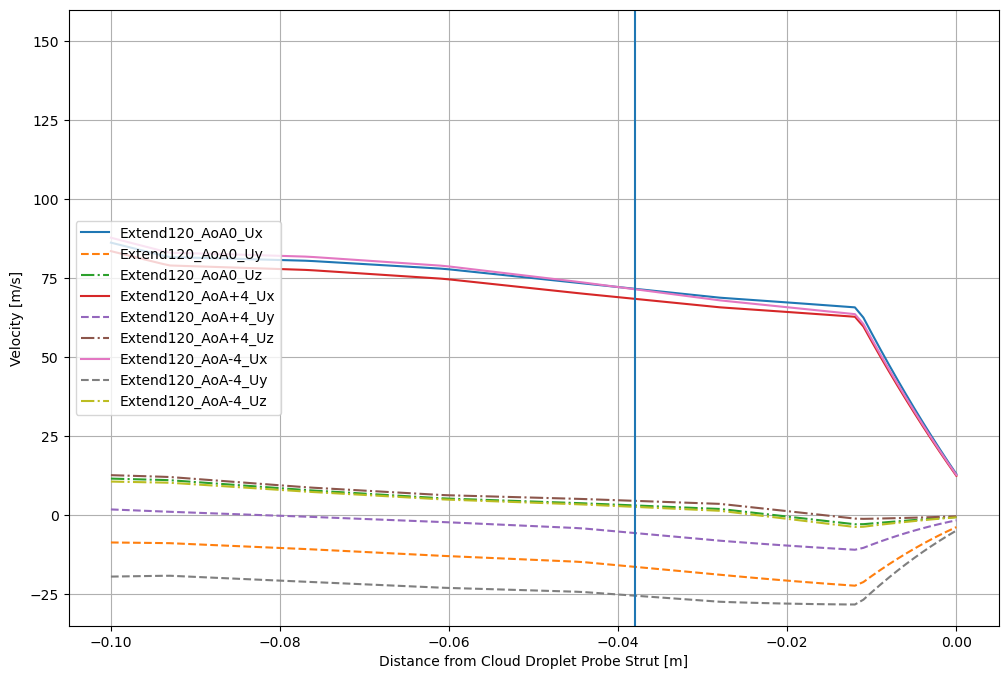

In [18]:
# Process the selected Scalar fields over the line
plot_line(solution_dir, 
          extend_120_line, 
          FIELD='U',
          SAVE=True)

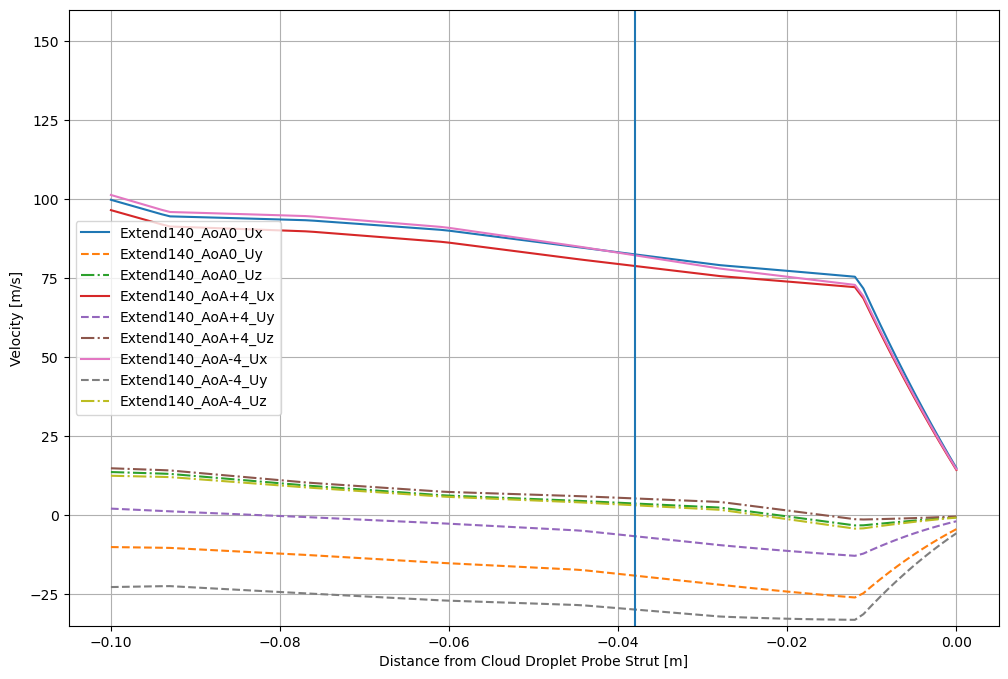

In [19]:
# Process the selected Scalar fields over the line
plot_line(solution_dir, 
          extend_140_line, 
          FIELD='U',
          SAVE=True)

In [20]:
navy_120_line = [case_120['navy_120_aoa0'], case_120['navy_120_aoaPos4'], case_120['navy_120_aoaNeg4']]
navy_140_line = [case_140['navy_140_aoa0'], case_140['navy_140_aoaPos4'], case_140['navy_140_aoaNeg4']]

2023-07-26 18:39:02.449 (1373.934s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:39:13.974 (1385.459s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:39:25.501 (1396.987s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


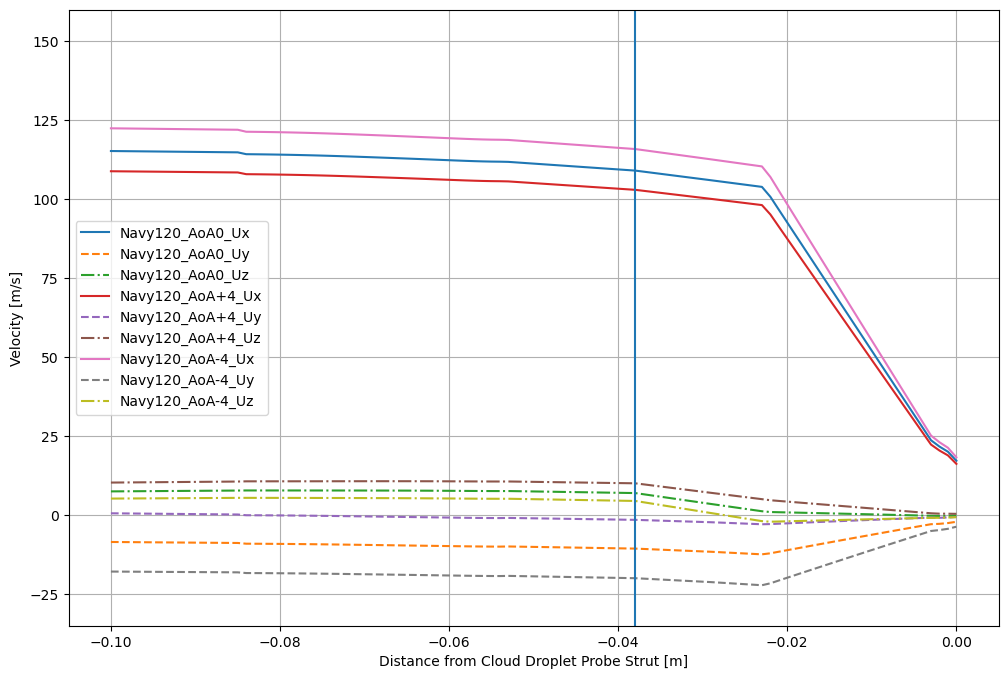

In [21]:
# Process the selected Scalar fields over the line
plot_line(solution_dir, 
          navy_120_line, 
          FIELD='U',
          SAVE=True)

2023-07-26 18:39:37.099 (1408.585s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:39:48.572 (1420.058s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:40:00.053 (1431.539s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


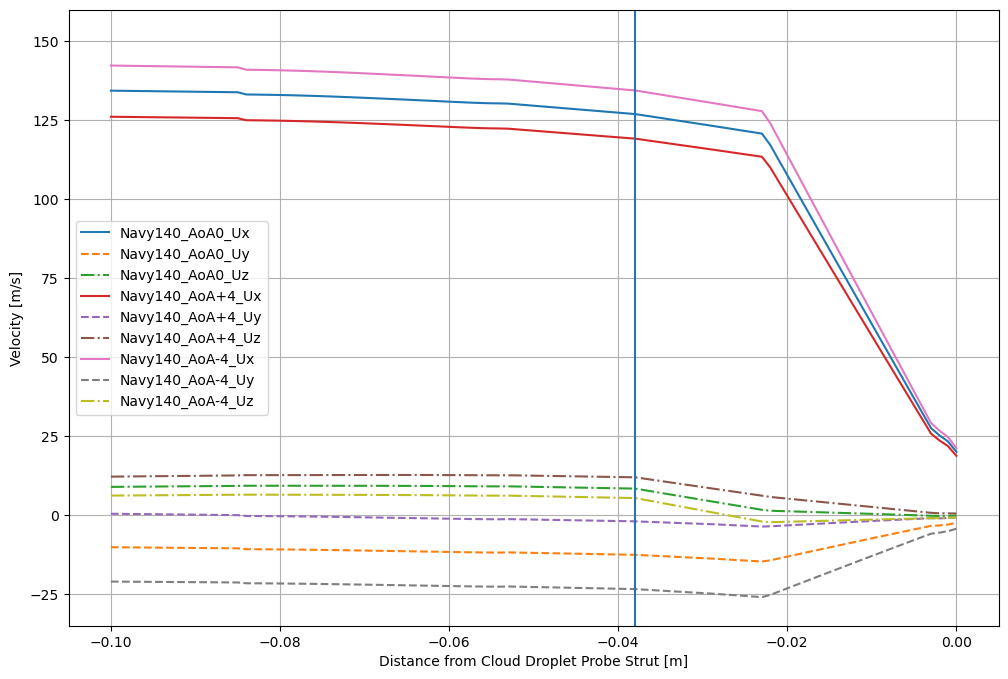

In [22]:
# Process the selected Scalar fields over the line
plot_line(solution_dir, 
          navy_140_line, 
          FIELD='U',
          SAVE=True)

### H) Value within CDP Sample Volume

In [23]:
cdp_navy_120 = sample_volume(solution_dir,
                             navy_120_line,
                             FIELD='U'
                            )

2023-07-26 18:40:11.671 (1443.157s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-07-26 18:40:23.192 (1454.679s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Navy120_AoA0 [109.07605  -10.584614   6.992657]
Navy120_AoA+4 [102.987175   -1.4845028  10.082008 ]
Navy120_AoA-4 [115.89747  -19.956003   4.498146]


2023-07-26 18:40:34.652 (1466.139s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


In [24]:
cdp_navy_140 = sample_volume(solution_dir,
                             navy_140_line,
                             FIELD='U'
                            )

2023-07-26 18:40:46.141 (1477.628s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Navy140_AoA0 [126.96852  -12.557798   8.403991]
Navy140_AoA+4 [119.18748    -1.9579902  11.982219 ]


2023-07-26 18:40:57.595 (1489.081s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Navy140_AoA-4 [134.44511   -23.40407     5.4121456]


2023-07-26 18:41:09.065 (1500.551s) [           9D925]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


In [25]:
cdp_extend_120 = sample_volume(solution_dir,
                             extend_120_line,
                             FIELD='U'
                            )

Extend120_AoA0 [ 71.647934 -16.372137   3.07285 ]
Extend120_AoA+4 [68.46866   -5.6719894  4.52588  ]
Extend120_AoA-4 [ 71.50642  -25.49675    2.617618]


In [26]:
cdp_extend_140 = sample_volume(solution_dir,
                             extend_140_line,
                             FIELD='U'
                            )

Extend140_AoA0 [ 82.543625  -19.152905    3.6805859]
Extend140_AoA+4 [78.87019   -6.677492   5.2871346]
Extend140_AoA-4 [ 82.25195   -29.884253    3.1250114]


In [27]:
no_line = [case_120['no_120_aoa0']]
no_120 = sample_volume(solution_dir,
                       no_line,
                       FIELD='U'
                       )

Null120_AoA0 [118.49963    -1.5518469   3.0030942]
